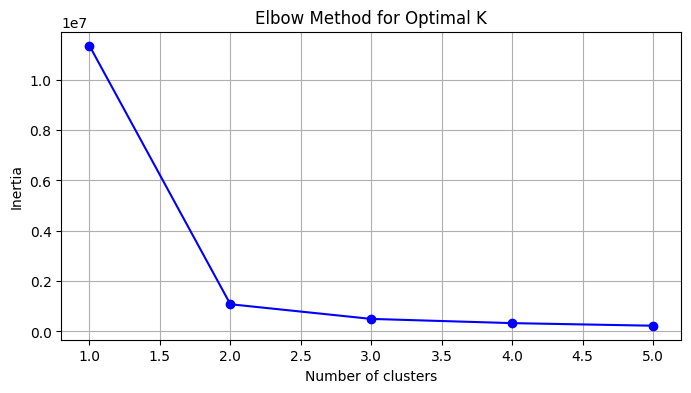

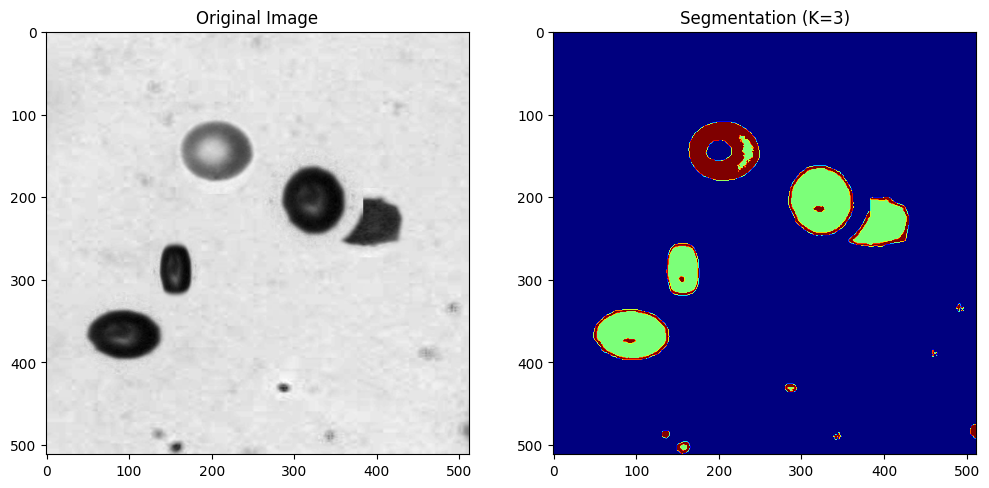

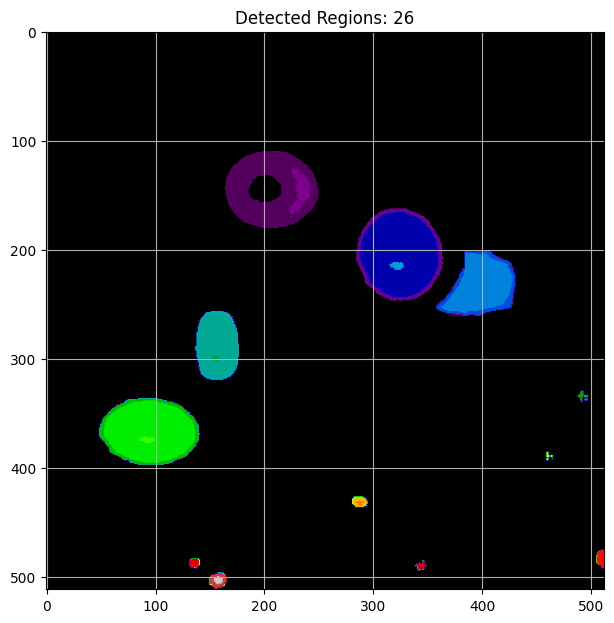

Silhouette Score: 0.908


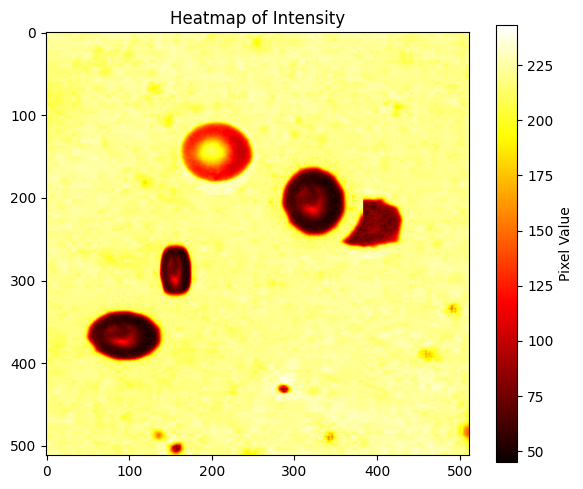

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from skimage import measure
import random
from time import time

class ImageProcessor:
    def __init__(self, bg_folder='background', patch_folder='patches'):
        self.bg_images = self._load_images(bg_folder)
        self.patch_images = self._load_images(patch_folder)

    def _load_images(self, folder):
        images = []
        for f in os.listdir(folder):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = cv2.imread(os.path.join(folder, f), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
        return images

    def generate_composite(self, size=(512, 512)):
        bg = cv2.resize(random.choice(self.bg_images), (size[1], size[0]))

        for _ in range(random.randint(3, 7)):
            patch = random.choice(self.patch_images)
            h, w = random.randint(50, 150), random.randint(50, 150)
            patch = cv2.resize(patch, (w, h))

            x = random.randint(0, size[0] - h)
            y = random.randint(0, size[1] - w)

            # Alpha blending
            mask = np.zeros((h, w), dtype=np.float32)
            cv2.circle(mask, (w//2, h//2), min(w,h)//2, 1, -1)
            mask = cv2.GaussianBlur(mask, (15, 15), 0)

            bg[x:x+h, y:y+w] = (bg[x:x+h, y:y+w] * (1-mask) + patch * mask).astype(np.uint8)

        return bg

    def plot_elbow_method(self, image, max_k=5):
        pixels = image.reshape(-1, 1)
        if len(pixels) > 10000:
            pixels = pixels[np.random.choice(len(pixels), 10000, replace=False)]

        inertias = []
        for k in range(1, max_k+1):
            kmeans = MiniBatchKMeans(n_clusters=k, random_state=42).fit(pixels)
            inertias.append(kmeans.inertia_)

        plt.figure(figsize=(8, 4))
        plt.plot(range(1, max_k+1), inertias, 'bo-')
        plt.xlabel('Number of clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal K')
        plt.grid()
        plt.show()

        return 2 if max_k < 3 else 3  # Default to 3 clusters

    def segment_image(self, image, n_clusters=3):
        pixels = image.reshape(-1, 1)
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(pixels)
        labels = kmeans.predict(pixels)
        return labels.reshape(image.shape)

    def analyze_regions(self, segmented):
        labeled = measure.label(segmented)
        regions = measure.regionprops(labeled)

        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.imshow(labeled, cmap='nipy_spectral')
        plt.title(f'Detected Regions: {len(regions)}')


        plt.grid()

        plt.tight_layout()
        plt.show()

        return regions

    def calculate_metrics(self, image, segmented):
        h, w = image.shape
        step = 2 if h > 512 or w > 512 else 1
        sample_img = image[::step, ::step]
        sample_seg = segmented[::step, ::step]

        if sample_img.size > 10000:
            idx = np.random.choice(sample_img.size, 10000, replace=False)
            return silhouette_score(sample_img.reshape(-1, 1)[idx],
                                   sample_seg.reshape(-1)[idx])
        else:
            return silhouette_score(sample_img.reshape(-1, 1),
                                   sample_seg.reshape(-1))

    def process_image(self):
        img = self.generate_composite()
    

        optimal_k = self.plot_elbow_method(img)

        segmented = self.segment_image(img, optimal_k)

        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')

        plt.subplot(122)
        plt.imshow(segmented, cmap='jet')
        plt.title(f'Segmentation (K={optimal_k})')
        plt.show()

        regions = self.analyze_regions(segmented)

        score = self.calculate_metrics(img, segmented)
        print(f"Silhouette Score: {score:.3f}")

        plt.figure(figsize=(6, 5))
        plt.imshow(img, cmap='hot')
        plt.title('Heatmap of Intensity')
        plt.colorbar(label='Pixel Value')
        plt.tight_layout()
        plt.show()

        return img, segmented, regions


bg_folder = '/Users/nident/Desktop/RSREU/МФТИ/2семак/blood_cells_dataset/fon'
patch_folder = '/Users/nident/Desktop/RSREU/МФТИ/2семак/blood_cells_dataset/patch'
processor = ImageProcessor(bg_folder=bg_folder, patch_folder=patch_folder)
original, segmented, regions = processor.process_image()
